In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import heeps
from heeps.util.coord import polar_coord, cart_coord
from heeps.util.img_processing import resize_img
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


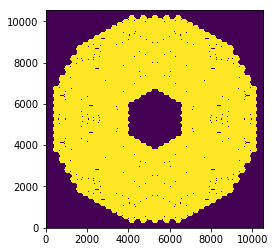

In [3]:
folder = '$HOME/INSTRUMENTS/METIS/ELT_pupils'
folder = os.path.normpath(os.path.expandvars(folder))
spiders = fits.getdata(os.path.join(folder, 'SpiderShadow.fits'))
segment = fits.getdata(os.path.join(folder, 'SegmentationPattern.fits'))
plt.imshow(segment, origin=True)

## Create all-glass mask

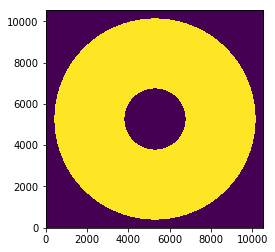

In [4]:
pupil_img_size = 39.9988
diam_ext = 36.905
diam_int = 11.213
npupil = np.shape(segment)[0]
dn = 2/npupil
pup_range = np.arange(-1, 1, dn) + dn/2
xi,yi = np.meshgrid(pup_range, pup_range)
ri = np.abs(xi + 1j*yi)
mask_allglass = (ri > diam_int/pupil_img_size) * (ri < diam_ext/pupil_img_size)
plt.imshow(mask_allglass, origin=True)
#fits.writeto(os.path.join(folder, 'mask_allglass.fits'), \
#             np.uint8(mask_allglass), overwrite=True)

## Invert masked pupil for manual inspection

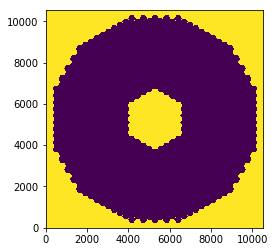

In [4]:
segment_neg = 1 - segment
segment_neg[mask_allglass] = 0
plt.imshow(segment_neg, origin=True)
#fits.writeto(os.path.join(folder, 'mask_M1_neg_imperfect.fits'), \
#             np.uint8(segment_neg), overwrite=True)

## Load pupil with manually removed residuals

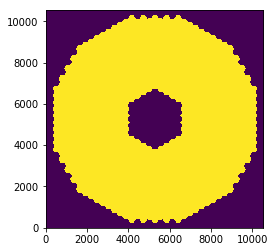

In [4]:
M1 = fits.getdata(os.path.join(folder, 'mask_M1.fits'))
plt.imshow(M1, origin=True)

## Add spiders

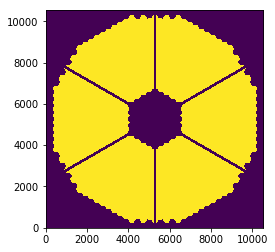

In [6]:
M1_spi = M1 * spiders
plt.imshow(M1_spi, origin=True)

## Calculate pupil translations
### 1- segmented pupil

In [7]:
def pupil_translat(pupil, translat, ring_thick=1e-2):
    npupil = pupil.shape[0]
    translat_size = int(np.ceil(translat*npupil))
    translat_size += 1 - translat_size % 2
    dn = 2/(translat_size - 1)
    translat_range = np.arange(-1, 1+dn, dn)
    x,y = np.meshgrid(translat_range, translat_range)
    r = np.abs(x + 1j*y)
    r_max = translat*npupil/translat_size
    ring = (r < r_max) * (r > r_max*(1 - ring_thick))
    margin = int((translat_size - 1)/2)
    pupil_stop = np.ones((npupil + 2*margin, npupil + 2*margin))
    for i in range(translat_size):
        print(i)
        for j in range(translat_size):
            if ring[i,j] == True:
                pupil_stop[i:i-2*margin, j:j-2*margin] *= pupil
    pupil_stop = pupil_stop[margin:-margin,margin:-margin]
    return pupil_stop, ring 

In [8]:
diam_nominal_pupil = 38.542
translat_seg = 0.0282*diam_nominal_pupil/pupil_img_size
pupil_stop_seg, ring_seg = pupil_translat(M1, translat_seg)
plt.imshow(pupil_stop_seg, origin=True)
pupil_stop_seg.shape

In [9]:
translat_spi = 0.037*diam_nominal_pupil/pupil_img_size
pupil_stop_spi, ring_spi = pupil_translat(spiders, translat_spi)
plt.imshow(pupil_stop_spi, origin=True)
pupil_stop_spi.shape

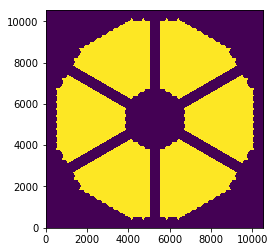

In [10]:
pupil_stop = pupil_stop_seg*pupil_stop_spi
plt.imshow(pupil_stop, origin=True)
fits.writeto(os.path.join(folder, 'pupil_stop.fits'), \
             np.uint8(pupil_stop), overwrite=True)

a1  =1.047361824823104
pi/3=1.0471975511965976

a2  =0.5233678423036151
a4  =0.5240965688553664
pi/6=0.5235987755982988


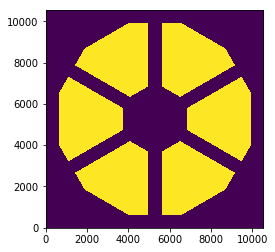

In [124]:
# outer edge
P1 = (802,6825)
a1 = (8303-P1[1])/(1655-P1[0])
P2 = (1847,8659)
a2 = (9775-P2[1])/(3781-P2[0])
x3 = 615
y3 = 618
nplus1 = 10526 + 1
x,y = np.meshgrid(np.arange(1, nplus1),np.arange(1, nplus1))
M1 = (y < a1*x + P1[1] - a1*P1[0]) \
   * (y < -a1*x + P1[1] + a1*(nplus1 - P1[0])) \
   * (y > a1*x + (nplus1 - P1[1]) - a1*(nplus1 - P1[0])) \
   * (y > -a1*x + (nplus1 - P1[1]) + a1*P1[0])
M2 = (y < a2*x + P2[1] - a2*P2[0]) \
   * (y < -a2*x + P2[1] + a2*(nplus1 - P2[0])) \
   * (y > a2*x + (nplus1 - P2[1]) - a2*(nplus1 - P2[0])) \
   * (y > -a2*x + (nplus1 - P2[1]) + a2*P2[0])
M3 = (x > x3) * (x < nplus1 - x3) * (y > y3) * (y < nplus1 - y3)
# inner edge
P4 = (4218, 6424)
a4 = (6750-P4[1])/(4782-P4[0])
x5 = 3736
y5 = 3749
M4 = (y > a4*x + P4[1] - a4*P4[0]) \
   + (y > -a4*x + P4[1] + a4*(nplus1 - P4[0])) \
   + (y < a4*x + (nplus1 - P4[1]) - a4*(nplus1 - P4[0])) \
   + (y < -a4*x + (nplus1 - P4[1]) + a4*P4[0])
M5 = (x < x5) + (x > nplus1 - x5) #+ (y < y5) + (y > nplus1 - y5)
mask = (M1 * M2 * M3) * (M4 + M5)
APP_stop = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/APP_stop_round.fits')
APP_stop *= mask
plt.imshow(APP_stop, origin=True)
fits.writeto('APP_stop.fits', np.uint8(APP_stop), overwrite=True)
print('a1  =%s\npi/3=%s\n'%(np.arctan(a1), np.pi/3))
print('a2  =%s\na4  =%s\npi/6=%s'%(np.arctan(a2), np.arctan(a4), np.pi/6))

In [5]:
from heeps.util.img_processing import resize_img
fits.writeto('APP_stop_L.fits', np.float32(resize_img(np.float32(APP_stop), 285)), overwrite=True)
fits.writeto('APP_stop_M.fits', np.float32(resize_img(np.float32(APP_stop), 227)), overwrite=True)
fits.info('APP_stop_L.fits')

NameError: name 'APP_stop' is not defined

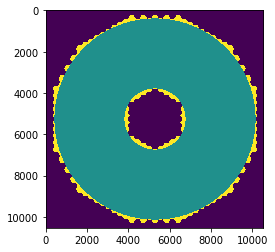

In [7]:
# check all glass
fullM1 = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupils/mask_M1.fits'))
allglass = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupils/mask_allglass.fits'))
imshow(fullM1 - allglass/2)

In [8]:
# calculate LS params (r_ext, r_int)
npupil = fullM1.shape[0]
xi, yi = cart_coord(npupil)
pupil_img_size = 39.9988
diam_nominal = 38.542
diam_ext = 36.905
diam_int = 11.213
ls_dRext = 0.0282
ls_dRint = 0.0282
seg_width = 1.45
ds = seg_width*np.sin(np.pi/3)
dc = seg_width*np.cos(np.pi/3)
A = np.arcsin(dc/diam_int)
h = np.cos(A)*diam_int
diam_int_eff = h - ds + seg_width/np.cos(np.pi/6)
r_ext = (diam_ext     - ls_dRext*diam_nominal)                 / pupil_img_size
r_int = (diam_int_eff + ls_dRint*diam_nominal/np.cos(np.pi/6)) / pupil_img_size
print('diam_int_eff=%3.4f'%diam_int_eff)
print('r_ext=%3.4f, r_int=%3.4f'%(r_ext, r_int))

diam_int_eff=11.6081
r_ext=0.8955, r_int=0.3216


In [9]:
def mask_angle(x, y, r, theta, rot):
    P = (r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta)))
    a = np.tan(np.deg2rad(theta - rot))
    b = P[1] - a*P[0]
    mask = (y > a*x + b) + (y > -a*x + b) + (y < a*x - b) + (y < -a*x - b)
    return mask

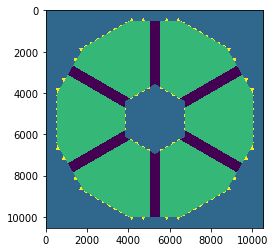

In [10]:
# r_ext dodecagon
M1 = mask_angle(xi, yi, r_ext, 0 , 90)
M2 = mask_angle(xi, yi, r_ext, 30, 90)
M3 = mask_angle(xi, yi, r_ext, 60, 90)
M4 = mask_angle(xi, yi, r_ext, 90, 90)
# r_int hexagon
M5 = mask_angle(xi, yi, r_int, 30, 60)
M6 = mask_angle(xi, yi, r_int, 30, 120)
# apply mask
mask = M1 + M2 + M3 + M4 + ~(M5 + M6)
pup = np.float32(fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/lyot_stop.fits'))
ls_mask = pup*(1-mask)
#fits.writeto('/Users/cdelacroix/Desktop/lyot_stop_dodecagon.fits', np.uint8(ls_mask), overwrite=True)
#fits.writeto('/Users/cdelacroix/Desktop/lyot_stop_dodecagon_285.fits', resize_img(ls_mask, 285), overwrite=True)
pup[mask] += 0.5
imshow(pup)


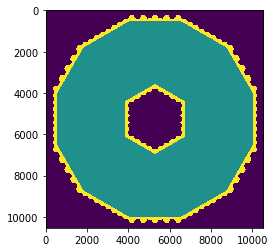

In [13]:
pup = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupils/mask_M1.fits'))
pup[mask] += 0.5
imshow(pup)

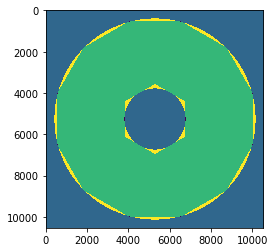

In [15]:
pup = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupils/mask_allglass.fits'))
pup[mask] += 0.5
imshow(pup)

# RAVC Lyot stop

In [16]:
# fullM1 RA radius wrt allglass (calc=False)
ravc_r = 0.6033
r_int_ravc = (ravc_r*diam_ext + ls_dRint*diam_nominal)/pupil_img_size
print(ravc_r, r_int_ravc)
ri,ti = polar_coord(npupil)
mask = (ri > r_int_ravc) * (ri < r_ext)
ls_ravc = ls_mask*mask
#fits.writeto('/Users/cdelacroix/Desktop/ls_ravc_circ.fits', np.uint8(ls_ravc), overwrite=True)
fits.writeto('/Users/cdelacroix/Desktop/ls_ravc_circ_285.fits', resize_img(ls_ravc, 285), overwrite=True)

0.6033 0.5838092867786033
36.905 11.213 0.6212896682141414


In [25]:
# all glass pupil: LS more agfgressive because diam_int much smaller
r_obstr = diam_int/diam_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4
ravc_r = r_obstr/np.sqrt(1 - ravc_t)
r_int_ravc = (ravc_r*diam_ext + ls_dRint*diam_nominal)/pupil_img_size
print(ravc_r, r_int_ravc)
ri,ti = polar_coord(npupil)
mask = (ri > r_int_ravc) * (ri < r_ext)
ls_ravc = ls_mask*mask
#fits.writeto('/Users/cdelacroix/Desktop/ls_ravc_allglass.fits', np.uint8(ls_ravc), overwrite=True)
fits.writeto('/Users/cdelacroix/Desktop/ls_ravc_allglass_285.fits', resize_img(ls_ravc, 285), overwrite=True)

0.26357489599557504 0.15896432692759532


# CVC Lyot stop

In [7]:
ls_dRint = 0.05
r_int = (diam_int_eff + ls_dRint*diam_nominal/np.cos(np.pi/6)) / pupil_img_size
# r_int hexagon
M5 = mask_angle(xi, yi, r_int, 30, 60)
M6 = mask_angle(xi, yi, r_int, 30, 120)
# apply mask
mask = ~(M5 + M6)
ls_cvc = ls_mask*(1-mask)
fits.writeto('/Users/cdelacroix/Desktop/ls_cvc.fits', np.uint8(ls_cvc), overwrite=True)
fits.writeto('/Users/cdelacroix/Desktop/ls_cvc_285.fits', resize_img(ls_cvc, 285), overwrite=True)

# Allglass Lyot stop

In [7]:
pup = np.float32(fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/lyot_stop.fits'))
ri,ti = polar_coord(npupil)
r_ext = (diam_ext - margin*diam_nominal) / pupil_img_size
r_int = (diam_int + margin*diam_nominal) / pupil_img_size
mask = (ri > r_int) * (ri < r_ext)
fits.writeto('/Users/cdelacroix/Desktop/lyot_stop_circ.fits', np.uint8(pup*mask), overwrite=True)
fits.writeto('/Users/cdelacroix/Desktop/lyot_stop_circ_285.fits', resize_img(pup*mask, 285), overwrite=True)

# APP stop (with Talbot effect)

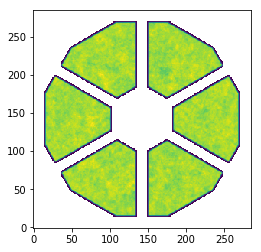

In [3]:
# load APP masks
APPL = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/APP_stop_L_285.fits')
APPM = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/APP_stop_M_227.fits')
# load amplitude
talbot = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/NCPA/Tibor_Andre/Talbot_LM_20201120/IMGP_rep_1_field_50.fits')
talbot = talbot[1:,1:] # odd-centered (511x511)
talbot285 = resize_img(talbot, 285)*np.sqrt(APPL)
talbot227 = resize_img(talbot, 227)*np.sqrt(APPM)
fits.writeto('APP_stop_talbot_L_285_I.fits', np.float32(talbot285**2), overwrite=True)
fits.writeto('APP_stop_talbot_M_227_I.fits', np.float32(talbot227**2), overwrite=True)
talbot1=1*talbot285
talbot1[talbot1==0] = np.nan
fits.writeto('inspect_APP_talbot_greyscale.fits', np.float32(talbot1), overwrite=True)
imshow(talbot1, origin=True)

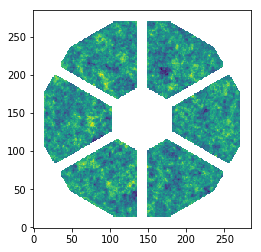

In [12]:
talbot1 = 1*talbot285
talbot1[talbot1<0.5] = -1
talbot1[APPL==0] = np.nan
fits.writeto('APP_stop_talbot_L_285.fits', np.float32(talbot1), overwrite=True)
imshow(talbot1, origin=True)